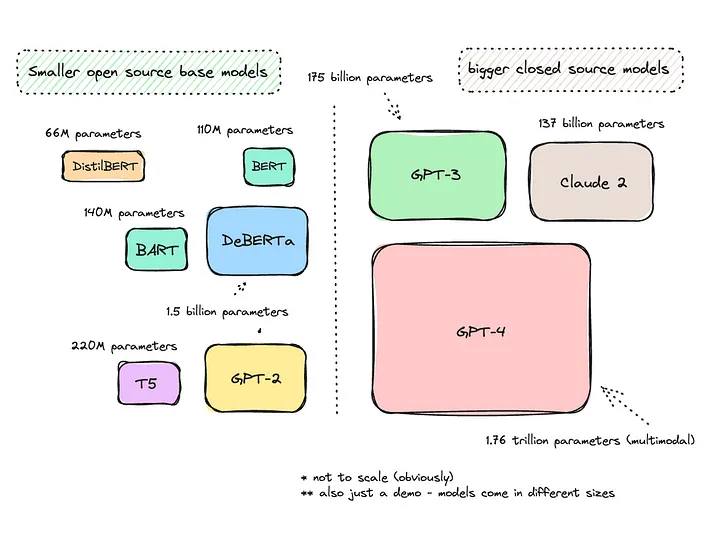

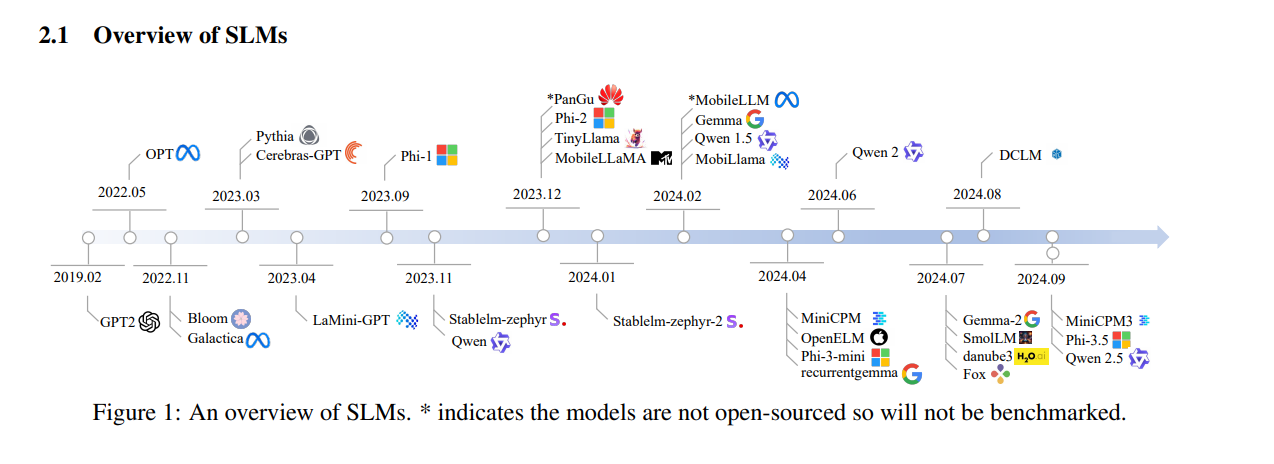

https://huggingface.co/blog/4bit-transformers-bitsandbytes

https://github.com/ashishpatel26/LLM-Finetuning

https://www.ibm.com/topics/instruction-tuning

In [1]:
!nvidia-smi

Wed Jan  8 10:54:15 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Finetune Llama-2-7b on a Google colab
Welcome to this Google Colab notebook that shows how to fine-tune the recent Llama-2-7b model on a single Google colab and turn it into a chatbot

We will leverage PEFT library from Hugging Face ecosystem, as well as QLoRA for more memory efficient finetuning

# Setup
Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and `TRL` to leverage the recent `SFTTrainer`. We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install einops as it is a requirement to load Falcon models.

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0,

# Dataset

 Instruction tuning is a technique for fine-tuning large language models (LLMs) on a labeled dataset of instructional prompts and corresponding outputs.

In [ ]:
from huggingface_hub import login
login()
# huggingface_hub Access Tokens: ''

In [ ]:
from datasets import load_dataset

dataset_name = 'nisaar/Articles_Constitution_3300_Instruction_Set'
dataset = load_dataset(dataset_name, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

(…)2_14_15_19_21_Instructionset_train.jsonl:   0%|          | 0.00/8.01M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3311 [00:00<?, ? examples/s]

In [ ]:
print(type(dataset))
print(len(dataset))
dataset[1]

<class 'datasets.arrow_dataset.Dataset'>
3311


{'instruction': 'Identify and summarize the key legal issues in the provided case.',
 'input': 'Case Citation: Central Inland Water Transport Corporation Ltd. vs Brojo Nath Ganguly & Anr., 1986 AIR 1571, 1986 SCR (2) 278. The case revolves around the termination of employment of the respondents by the appellant without assigning any reason by invoking Rule 9(i) of the service rules. The respondents challenged the termination orders and the validity of Rule 9(i) in the High Court under Article 226. The Division Bench of the High Court struck down Rule 9(i) as arbitrary and violative of Article 14. The appellant filed appeals in the Supreme Court against the High Court judgment.',
 'output': "The key legal issues in the case Central Inland Water Transport Corporation Ltd. vs Brojo Nath Ganguly & Anr. are as follows: 1. The first issue is whether a government company falls under the definition of 'State' as per Article 12 of the Indian Constitution. This is important as the constitutional

In [ ]:
print(dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'prompt'],
    num_rows: 3311
})


In [ ]:
from datasets import Dataset

# Assuming `dataset` is your Dataset object
dataset = dataset.map(lambda example: {'text': example['prompt'] + example['output']})

Map:   0%|          | 0/3311 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'text'],
    num_rows: 3311
})

# Loading the Model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "TinyPixel/Llama-2-7B-bf16-sharded"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/981M [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/944M [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/944M [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/847M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [ ]:
from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

In [ ]:
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
from transformers import TrainingArguments

In [ ]:
output_dir = "./results"
per_device_train_batch_size = 1
gradient_accumulation_steps = 2
optim = "paged_adamw_32bit"
save_steps = 1
num_train_epochs = 4
logging_steps = 1
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 20
warmup_ratio = 0.03
lr_scheduler_type = "linear"

In [ ]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [ ]:
from trl import SFTTrainer

In [ ]:
max_seq_length = 2048

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/3311 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [ ]:
trainer.train()
# d2bf654d0ef244f5623fc9b023aceaa087e12584

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 127.06 MiB is free. Process 28303 has 14.62 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 392.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("outputs")

In [ ]:
lora_config = LoraConfig.from_pretrained('outputs')
model = get_peft_model(model, lora_config)

In [ ]:
model.push_to_hub("ashishpatel26/Llama2_Finetuned_Articles_Constitution_3300_Instruction_Set",create_pr=1)

adapter_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashishpatel26/Llama2_Finetuned_Articles_Constitution_3300_Instruction_Set/commit/0e6e09e0e362c05fdb5bee1d181514793a1eecaa', commit_message='Upload model', commit_description='', oid='0e6e09e0e362c05fdb5bee1d181514793a1eecaa', pr_url='https://huggingface.co/ashishpatel26/Llama2_Finetuned_Articles_Constitution_3300_Instruction_Set/discussions/1', pr_revision='refs/pr/1', pr_num=1)

In [ ]:
dataset['text'][0]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAnalyze and explain the legal reasoning behind the judgment in the given case.\n\n### Input:\nCentral Inland Water Transport Corporation Ltd. vs Brojo Nath Ganguly & Anr., 1986 AIR 1571, 1986 SCR (2) 278\n\n### Response:The Supreme Court in this case applied a broad interpretation of the term 'State' under Article 12 of the Constitution. The court reasoned that a government company undertaking public functions qualifies as 'State' based on factors like government control, public importance of activities etc. This interpretation was based on previous decisions that have defined 'State' under Article 12 broadly to include various agencies and instrumentalities beyond just statutory bodies. The court also applied the principle that unreasonable and arbitrary contractual terms can be struck down under Article 14 

In [ ]:
dataset['output'][0]

"The Supreme Court in this case applied a broad interpretation of the term 'State' under Article 12 of the Constitution. The court reasoned that a government company undertaking public functions qualifies as 'State' based on factors like government control, public importance of activities etc. This interpretation was based on previous decisions that have defined 'State' under Article 12 broadly to include various agencies and instrumentalities beyond just statutory bodies. The court also applied the principle that unreasonable and arbitrary contractual terms can be struck down under Article 14 of the Constitution. The court found that Rule 9(i) of the service rules, which allowed for termination of service without reason, conferred unfettered power to terminate employment without hearing. This was deemed arbitrary and violative of principles of natural justice and right to equality under Article 14. Furthermore, the court held that the right to life and livelihood under Article 21 is a

In [ ]:
text = dataset['text'][0]
device = "cuda:0"

In [ ]:
inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Analyze and explain the legal reasoning behind the judgment in the given case.

### Input:
Central Inland Water Transport Corporation Ltd. vs Brojo Nath Ganguly & Anr., 1986 AIR 1571, 1986 SCR (2) 278

### Response:The Supreme Court in this case applied a broad interpretation of the term 'State' under Article 12 of the Constitution. The court reasoned that a government company undertaking public functions qualifies as 'State' based on factors like government control, public importance of activities etc. This interpretation was based on previous decisions that have defined 'State' under Article 12 broadly to include various agencies and instrumentalities beyond just statutory bodies. The court also applied the principle that unreasonable and arbitrary contractual terms can be struck down under Article 14 of the Co